# Overview
This file visually showcases the effect of each preprocessings step on the data

In [63]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# supernovae_lst = pd.read_csv("./TESS_data/sn_count_transients_s1-47 (4).txt")
transients = pd.read_csv("./TESS_data/AT_count_transients_s1-47 (4).txt", names=["sector", "ra", "dec", "mag", "TJD_discovery", "type" ,"class", "IAU", "survey", "cam", "ccd", "col", "row"], delim_whitespace=True)
transients

,sector,ra,dec,mag,TJD_discovery,type,class,IAU,survey,cam,ccd,col,row
0,1,327.160083,-43.380019,17.800,1340.340,SN,SNIa,2018evo,ASAS-SN,1,1,1860.105,322.643
1,1,315.033417,-40.358594,17.869,1341.926,SN,SNIa,2018exc,ATLAS,1,1,528.652,1304.728
2,1,313.474583,-38.015594,18.781,1347.901,SN,SNII,2018fgb,ATLAS,1,1,424.192,1751.547
3,1,332.648000,-27.250161,16.700,1331.630,SN,SNII,2018emt,ASAS-SN,1,3,642.568,1607.839
4,1,327.584333,-26.300131,19.405,1337.965,AT,Unclassified,2018esp,ATLAS,1,3,1303.439,1157.924
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4398,47,167.461817,75.334383,20.670,2601.001,AT,Unclassified,2022aji,Pan-STARRS1,3,2,521.417,1084.865
4399,47,210.216792,78.085778,19.680,2601.143,AT,Unclassified,2022aha,Pan-STARRS1,3,3,1679.425,1415.721
4400,47,300.459933,85.849581,18.075,2588.733,AT,Unclassified,2022gn,ATLAS,3,4,1667.608,986.600
4401,47,256.141083,76.155150,18.470,2589.662,AT,Unclassified,2022op,GaiaAlerts,4,1,1990.840,279.007


In [64]:
light_curves = os.listdir("./TESS_data/light_curves_fausnaugh")
# name = light_curves[random.randint(0, len(light_curves)-1)]
# print(light_curves[i])
filename = "lc_2019mtt_cleaned"
curve = pd.read_csv("./TESS_data/light_curves_fausnaugh/" + filename, delim_whitespace=True)

#read AT_count file to find nonlight curve data of transient
curve_name = filename.split("_")[1]
curve_meta = transients[transients['IAU'] == curve_name]
display(curve_meta)

,sector,ra,dec,mag,TJD_discovery,type,class,IAU,survey,cam,ccd,col,row
484,14,301.320667,32.179539,13.25,1700.87699,AT,Unclassified,2019mtt,GaiaAlerts,1,1,1517.708,1749.542


In [65]:
curve['relative_time'] = curve['TJD'] - curve_meta["TJD_discovery"].iloc[0]
curve.index = pd.TimedeltaIndex(curve['relative_time'], unit="D")
plot_title = f"{curve_name}\n Class: {curve_meta['class'].iloc[0]}, Sector: {curve_meta['sector'].iloc[0]} \nCoords:{curve_meta['ra'].iloc[0], curve_meta['dec'].iloc[0]}, \nDiscovery TJD: {curve_meta['TJD_discovery'].iloc[0]}, Survey: {curve_meta['survey'].iloc[0]}"

def display_curve(col, error, title=""):
    return curve.plot.scatter(x="relative_time", y=col, c="00000", alpha=0.5, yerr=curve[error], ylabel="Flux", xlabel="Days relative to discovery", title=plot_title + title)

# Preprocessing steps
## 1. Sigma Clipping: remove points with flux uncertainties more than 3 sigma from mean uncertainty, repeat clipping 5 times

<AxesSubplot:title={'center':'2019mtt\n Class: Unclassified, Sector: 14 \nCoords:(301.32066667, 32.17953889), \nDiscovery TJD: 1700.87699, Survey: GaiaAlerts'}, xlabel='Days relative to discovery', ylabel='Flux'>

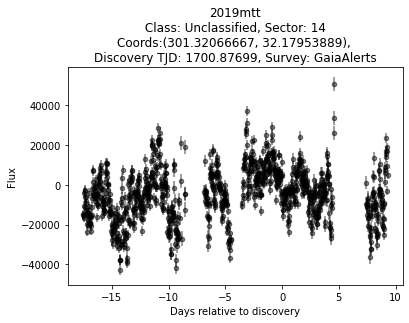

In [66]:

for _ in range(0, 5):
    uncert_mean = curve.e_cts.mean()
    threshold = 3*curve.e_cts.std()
    curve = curve[np.abs(curve['e_cts'] - uncert_mean) <= threshold]

display_curve("cts", "e_cts")

## 2. Subtract background Flux

<AxesSubplot:title={'center':'2019mtt\n Class: Unclassified, Sector: 14 \nCoords:(301.32066667, 32.17953889), \nDiscovery TJD: 1700.87699, Survey: GaiaAlerts'}, xlabel='Days relative to discovery', ylabel='Flux'>

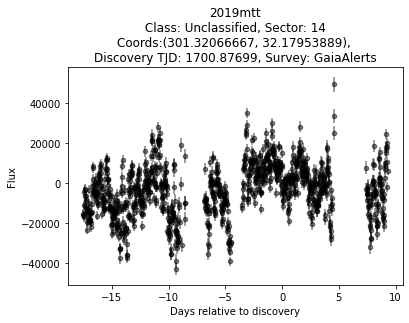

In [67]:
curve['no_bkg_cts'] = curve['cts'] - curve['bkg_model']
display_curve('no_bkg_cts', "e_cts")

## 3. Correct for milky way extinction using Fitzpatrick Reddening function
Wavelength of TESS bandpass is between 600-1000nm, central wavelength is 786.5nm

<AxesSubplot:title={'center':'2019mtt\n Class: Unclassified, Sector: 14 \nCoords:(301.32066667, 32.17953889), \nDiscovery TJD: 1700.87699, Survey: GaiaAlerts\nmwebw:3.2441'}, xlabel='Days relative to discovery', ylabel='Flux'>

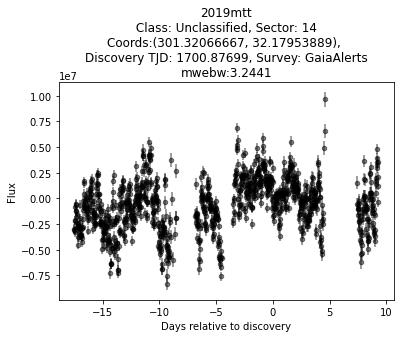

In [68]:
import extinction
from astroquery.irsa_dust import IrsaDust
import astropy.coordinates as coord
import astropy.units as u

# Set relevant parameters
ra = curve_meta["ra"].iloc[0]
dec = curve_meta["dec"].iloc[0]
flux_in = curve['no_bkg_cts']
fluxerr_in = curve["e_cts"]
bandpass_wavelengths = np.array([7865,])


# Get Milky Way E(B-V) Extinction
coo = coord.SkyCoord(ra * u.deg, dec * u.deg, frame='icrs')
dust = IrsaDust.get_query_table(coo, section='ebv')
mwebv = dust['ext SandF mean'][0]


# Remove extinction from light curves (Using negative a_v so that extinction.apply works in reverse and removes the extinction)
extinction_per_passband = extinction.fitzpatrick99(wave=bandpass_wavelengths, a_v=-3.1 * mwebv, r_v=3.1, unit='aa')
flux_out = extinction.apply(extinction_per_passband[0], flux_in, inplace=False)
fluxerr_out = extinction.apply(extinction_per_passband[0], fluxerr_in, inplace=False)

curve['unreddened_cts'] = flux_out
curve['unreddened_ects'] = fluxerr_out

display_curve('unreddened_cts', 'unreddened_ects', f"\nmwebw:{mwebv}")

In [69]:
#display all data
curve

,BTJD,TJD,cts,e_cts,bkg,bkg_model,bkg2,e_bkg2,relative_time,no_bkg_cts,unreddened_cts,unreddened_ects
relative_time,,,,,,,,,,,,
-18 days +11:27:47.232000,1683.36852,1683.35462,-14797.7146,2247.8726,-4587.1173,328.5072,5534.2246,2247.8726,-17.52237,-15126.2218,-2.950895e+06,438525.646310
-18 days +11:57:46.944000,1683.38935,1683.37545,-15293.0401,2265.6609,-1168.6941,328.5072,4464.1348,2265.6609,-17.50154,-15621.5473,-3.047526e+06,441995.872226
-18 days +12:27:47.520000,1683.41019,1683.39629,-16604.6638,2237.5959,-1765.3232,328.5072,4979.7361,2237.5959,-17.48070,-16933.1710,-3.303403e+06,436520.818941
-18 days +12:57:47.232000,1683.43102,1683.41712,-10545.0130,2230.4895,-1817.4111,328.5072,7037.6320,2230.4895,-17.45987,-10873.5202,-2.121258e+06,435134.468730
-18 days +13:27:46.944000,1683.45186,1683.43795,-15462.0136,2247.2443,-75.1974,328.5072,1241.3640,2247.2443,-17.43904,-15790.5208,-3.080490e+06,438403.074566
...,...,...,...,...,...,...,...,...,...,...,...,...
9 days 04:57:46.656000,1710.09783,1710.08378,18864.7570,2397.5366,-19337.3945,-1212.9592,1128.6003,2397.5366,9.20679,20077.7162,3.916856e+06,467722.809142
9 days 05:27:46.368000,1710.11866,1710.10461,17150.5086,2363.0363,-14564.2236,-1212.9592,3462.0881,2363.0363,9.22762,18363.4678,3.582432e+06,460992.327017
9 days 05:57:46.080000,1710.13949,1710.12544,9436.7646,2394.6732,-12992.5510,-1212.9592,6127.2637,2394.6732,9.24845,10649.7238,2.077599e+06,467164.203492


## 5. Bin Data
bins the data into 1 day intervals and takes the mean of each bin

In [70]:
#square e_cts to get variances
curve['var_ects'] = np.power(curve['e_cts'], 2)
#find avg cnts and avg variances
curve.index = pd.TimedeltaIndex(curve['relative_time'].round(), unit="D")
binned = curve.resample("1D").mean()
#sqrt avg vars to get uncertainty in stds
binned['e_cts'] = np.power(binned['var_ects'], 0.5)
binned = binned.fillna(0)
binned

,BTJD,TJD,cts,e_cts,bkg,bkg_model,bkg2,e_bkg2,relative_time,no_bkg_cts,unreddened_cts,unreddened_ects,var_ects
relative_time,,,,,,,,,,,,,
-18 days,1683.378935,1683.365035,-15045.377350,2256.784276,-2877.905700,328.507200,4999.179700,2256.766750,-17.511955,-15373.884550,-2.999210e+06,440260.759268,5.093075e+06
-17 days,1683.899779,1683.885870,-10744.121354,2296.081336,1133.665471,-616.571825,-1362.852854,2295.952892,-16.991120,-10127.549529,-1.975730e+06,447905.377607,5.271990e+06
-16 days,1684.899793,1684.885870,-4040.169360,2465.397312,-11841.264423,-244.857385,-388.818300,2463.068567,-15.991120,-3795.311975,-7.404075e+05,480507.095955,6.078184e+06
-15 days,1685.899807,1685.885870,-14180.687292,2565.055234,-5918.428583,-3838.154019,-3737.276027,2564.724669,-14.991120,-10342.533273,-2.017670e+06,500338.650407,6.579508e+06
-14 days,1686.899820,1686.885870,-20741.285598,2582.604491,-6244.089569,-3864.582171,-3682.857335,2582.461358,-13.991120,-16876.703427,-3.292387e+06,503798.807919,6.669846e+06
-13 days,1687.899612,1687.885645,-6186.001162,2594.021630,-11853.490902,-1861.651126,-946.204766,2593.484123,-12.991345,-4324.350036,-8.436147e+05,505949.181199,6.728948e+06
-12 days,1688.899846,1688.885867,-4466.142727,2609.448659,-20270.853340,-2242.136342,-2431.407196,2608.922138,-11.991123,-2224.006385,-4.338697e+05,508960.902196,6.809222e+06
-11 days,1689.899858,1689.885867,8222.450981,2582.073062,-34361.293740,584.963133,737.668310,2581.794608,-10.991123,7637.487848,1.489957e+06,503668.735167,6.667101e+06
-10 days,1690.899869,1690.885867,-10726.266146,2926.115349,24431.345948,601.603119,1250.937367,2920.607583,-9.991123,-11327.869265,-2.209894e+06,569765.976994,8.562151e+06


<AxesSubplot:title={'center':'2019mtt\n Class: Unclassified, Sector: 14 \nCoords:(301.32066667, 32.17953889), \nDiscovery TJD: 1700.87699, Survey: GaiaAlerts'}, xlabel='Days relative to discovery', ylabel='Flux'>

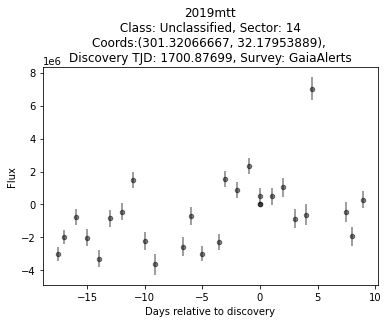

In [71]:
binned.plot.scatter(x="relative_time", y='unreddened_cts', c="00000", alpha=0.5, yerr=binned['unreddened_ects'], ylabel="Flux", xlabel="Days relative to discovery", title=plot_title)

# Find training labels
## 1. Max Light

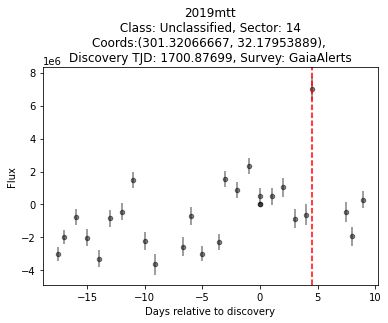

In [72]:
id_max = binned['unreddened_cts'].idxmax()
max_data = binned.loc[id_max, :]
t_max = max_data['relative_time']

ax = binned.plot.scatter(x="relative_time", y='unreddened_cts', c="00000", alpha=0.5, yerr=binned['unreddened_ects'], ylabel="Flux", xlabel="Days relative to discovery", title=plot_title)
ax.axvline(t_max, color="red", linestyle="--")

## 2. Explosion Time